In [1]:
import math
import pandas as pd
import bokeh
import sqlite3
import matplotlib as plt
import numpy as np
from bokeh.plotting import figure, output_file, show

In [100]:
# Debug: sqlite3 database - Connection is created between sqlite table and program, prints the table 
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return None

def select_task(conn):
    cur = conn.cursor()
    cur.execute("SELECT * FROM ants")
 
    rows = cur.fetchall()
    # print and check database data
    # for r in rows: print(r)  # DEBUG
    return None

if __name__ == '__main__':
    database = "/Volumes/NO NAME/ants_work/ants.db"
    conn = create_connection(database)
    select_task(conn)

In [134]:
# Uses connection to create a table of values from the sqlite table through pandas 
import pandas as pd

conn = sqlite3.connect("/Volumes/NO NAME/ants_work/ants.db")
df_orig = pd.read_sql_query("select * from ants;", conn)
# df_orig.sample(10)
df_orig.describe()

,ants_count
count,268.000000
mean,13.347015
std,8.230465
min,0.000000
25%,5.000000
50%,15.000000
75%,20.000000
max,30.000000


In [ ]:
# --- Helpful debugging statements...
# df[df['ants_count'].isnull()]  # Get rows that have NaN in them
# df[201] & df[231] have NaN for count
# df['ants_count'].fillna(0)

# df['time_diff'] = df.groupby('solution')['minute'].diff()  # find one diff with next row i.e. 1 min except when next hour
# Whereever there is diff of 41 due to hhmm rolling to next hour change it to 1.

In [139]:
# Perform imputation and more
from scipy.stats import mode
df = df_orig.copy(deep=True)  

df['ants_count'].fillna(mode(df['ants_count']).mode[0], inplace=True)  # Imput with mode
df['ants_count'] = df['ants_count'].astype(int)  # Convert float to int
# df_orig.sample(10)
df['ants_count'].groupby(df['solution']).describe()

,count,mean,std,min,25%,50%,75%,max
solution,,,,,,,,
banana,31.0,22.516129,4.537775,9.0,20.50,23.0,25.5,29.0
cayenne,29.0,19.827586,5.471151,11.0,15.00,20.0,23.0,30.0
cinnamon,27.0,4.259259,2.725839,0.0,2.00,4.0,5.5,10.0
control,31.0,4.580645,2.941362,0.0,2.00,4.0,7.0,10.0
lime,43.0,17.372093,4.670185,3.0,14.00,18.0,21.0,27.0
lime_spray,40.0,15.550000,2.782270,7.0,13.75,15.5,17.0,21.0
peppermint,29.0,19.275862,4.697237,9.0,16.00,18.0,23.0,29.0
vinegar,40.0,3.725000,2.764125,1.0,2.00,3.0,5.0,15.0


In [143]:
# Get Minute value from datetime stamp [YYYYmmDD_HHMMSS.jpeg].  
#  Experiements were all run on the same day and hence date can be ignored.

import re
pattern = '\d+_(\d{4})\d{2}.jpeg$'  # Get HHMM from YYYYmmDD_(HHMM)SS.jpeg

df['image'] = df['image'].str.replace('/home/pi/ant_images/', '')  # Remove full path of each image
df['minute'] = df['image'].str.extract(pattern,expand=False)
df['minute'] = df['minute'].astype(int)  # convert str to int type


# Find start-time(min value) for each solution and get difference (1 min for each consecutive row)
#  And special handle when hour rolls over with difference of 41 (xx59 to yy00)
df['time_diff'] = df['minute'] - df.groupby('solution')['minute'].transform('min')
df['time_diff_diff'] = df.groupby('solution')['minute'].diff()   # Compare to previous row value. Should be 1 or 41
df['time_diff_diff_1min'] = np.where(df['time_diff_diff'] == 41, df['time_diff_diff'] - 40, df['time_diff_diff'])
# df

# Now create cumulative sum for each group
df['x_coord'] = df.groupby(['solution'])['time_diff_diff_1min'].apply(lambda x: x.cumsum())
# df

# Set NaN (first row value of diffs) to 0 x-coordinate
df['x_coord'] = np.where(df['x_coord'].isnull(), 0.0, df['x_coord'])
# print(df.to_string())

df['ants_count'].groupby(df['solution']).describe()

,count,mean,std,min,25%,50%,75%,max
solution,,,,,,,,
banana,31.0,22.516129,4.537775,9.0,20.50,23.0,25.5,29.0
cayenne,29.0,19.827586,5.471151,11.0,15.00,20.0,23.0,30.0
cinnamon,27.0,4.259259,2.725839,0.0,2.00,4.0,5.5,10.0
control,31.0,4.580645,2.941362,0.0,2.00,4.0,7.0,10.0
lime,43.0,17.372093,4.670185,3.0,14.00,18.0,21.0,27.0
lime_spray,40.0,15.550000,2.782270,7.0,13.75,15.5,17.0,21.0
peppermint,29.0,19.275862,4.697237,9.0,16.00,18.0,23.0,29.0
vinegar,40.0,3.725000,2.764125,1.0,2.00,3.0,5.0,15.0


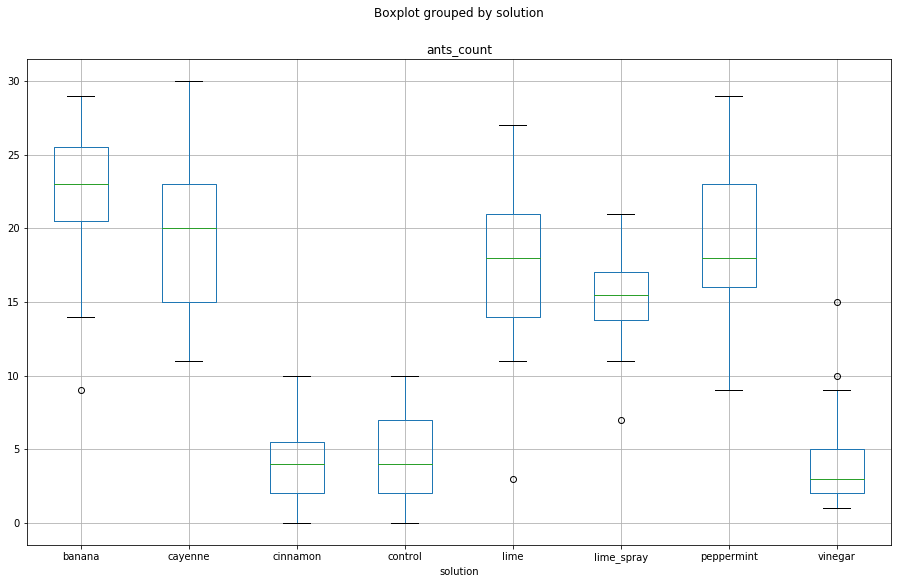

In [257]:
import matplotlib.pyplot as plt
%matplotlib inline
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange',
          'medians': 'DarkBlue', 'caps': 'Gray'}
plt.rcParams["figure.figsize"] = [15, 9]
# plt.title('Histogram of Counts of Ants Near Food with Repellents')
df.boxplot(column="ants_count", by="solution")
# df.plot.box(columns="ants_count", color=color, by="solution", )

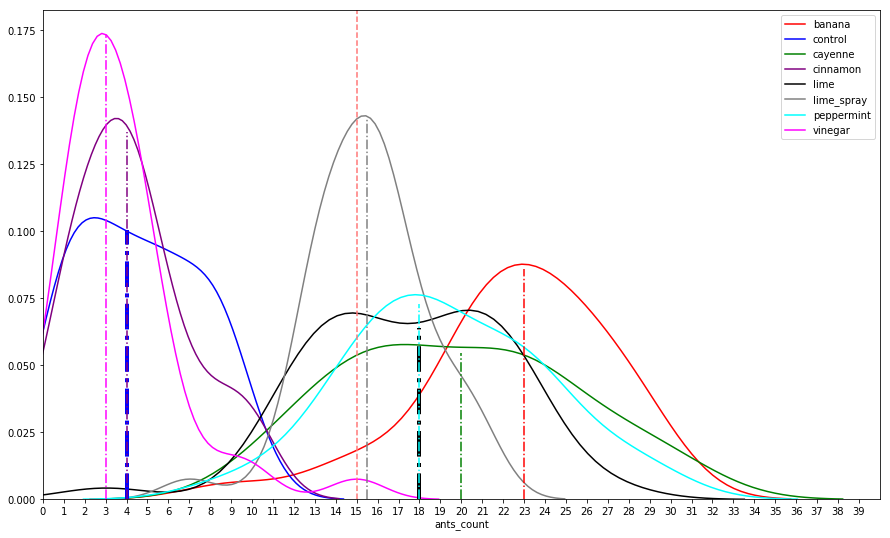

solution
banana        23.0
cayenne       20.0
cinnamon       4.0
control        4.0
lime          18.0
lime_spray    15.5
peppermint    18.0
vinegar        3.0
Name: ants_count, dtype: float64


In [256]:
# df.hist(column="ants_count", by="solution", bins=10)
import seaborn as sns

fig, ax = plt.subplots()

target_0 = df.loc[df['solution'] == 'banana']
target_1 = df.loc[df['solution'] == 'control']
target_2 = df.loc[df['solution'] == 'cayenne']
target_3 = df.loc[df['solution'] == 'cinnamon']
target_4 = df.loc[df['solution'] == 'lime']
target_5 = df.loc[df['solution'] == 'lime_spray']
target_6 = df.loc[df['solution'] == 'peppermint']
target_7 = df.loc[df['solution'] == 'vinegar']

sns.distplot(target_0['ants_count'], label='banana',  hist=False, color='red')
sns.distplot(target_1['ants_count'], label='control', hist=False, color='blue')
sns.distplot(target_2['ants_count'], label='cayenne', hist=False, color='green')
sns.distplot(target_3['ants_count'], label='cinnamon', hist=False,color='purple')
sns.distplot(target_4['ants_count'], label='lime', hist=False,    color='black')
sns.distplot(target_5['ants_count'], label='lime_spray', hist=False, color='gray')
sns.distplot(target_6['ants_count'], label='peppermint', hist=False, color='cyan')
sns.distplot(target_7['ants_count'], label='vinegar', hist=False, color='magenta')

ax.set_xlim(0,40) # We have 0 to 40 mins range
ax.set_xticks(range(0,40))

# Get median of all set...
full_median = df['ants_count'].agg('median')
plt.axvline(full_median, 0, 1, color='#ff7777', linestyle='--')

# Get Median of each solution
df_medians = df.groupby('solution')['ants_count'].agg('median')
plt.axvline(df_medians['banana'],  0, 0.47,   color='red',   linestyle='dashdot')
plt.axvline(df_medians['control'], 0, 0.55,   color='blue',  linestyle='dashdot', linewidth=4)
plt.axvline(df_medians['cayenne'], 0, 0.3,    color='green', linestyle='dashdot')
plt.axvline(df_medians['cinnamon'],0, 0.75,   color='purple',linestyle='dashdot')
plt.axvline(df_medians['lime'],    0, 0.35,    color='black', linestyle='dashdot', linewidth=4)
plt.axvline(df_medians['lime_spray'], 0, 0.78,color='gray',  linestyle='dashdot')
plt.axvline(df_medians['peppermint'], 0, 0.4, color='cyan',  linestyle='dashdot')
plt.axvline(df_medians['vinegar'],    0, 0.95,color='magenta',linestyle='dashdot')

plt.show()
print(df_medians)

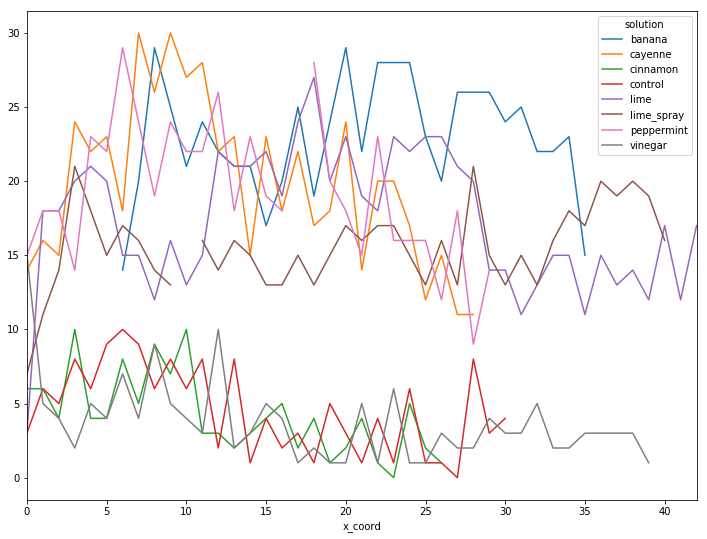

In [110]:
df_pt = df.pivot(index='x_coord', columns='solution', values='ants_count')
df_pt.plot()

In [254]:
# HISTOGRAM:
# ------------
# colors = ['red', 'green', 'blue', 'gray', 'yellow', 'purple', ]
# hists = df.hist( 
#            layout=(8,1), 
#            column="ants_count", by="solution", 
#            bins=5, 
#            sharex=True, sharey=True, 
#            xlabelsize=10,
#            figsize=(20,35),
#            color='k')
# # plt.tight_layout()
# # hists[0].set_xlabel("My x values")
# plt.suptitle('Ants count frequency',  ha='center', fontsize='xx-large')
# plt.show()

In [ ]:
df2 = pd.DataFrame()
f1 = interp1d(df1.x_coord, df1[''],kind='cubic')
dir(f1)
# f2 = interp1d(df1.index, df1['Weight_B'],kind='cubic')
# f3 = interp1d(df1.index, df1['Weight_C'],kind='cubic')

# df2['Weight_A'] = f1(new_index)
# df2['Weight_B'] = f2(new_index)
# df2['Weight_C'] = f3(new_index)
# df2.index = new_index
# 
# ax2 = df2.plot.line()
# ax2.set_title('After interpolation')
# ax2.set_xlabel("year")
# ax2.set_ylabel("weight")

In [52]:
# Find lists in the table, then create line graphs specific to each solution, possibly combine the line graphs later

time = []
for i in range(1, 31):
    time.append(i)

print(time)

output_file('antsgraph.html')
plot = figure(title = "Ant Count Over Time per Repellent", x_axis_label = "Time(min)", y_axis_label = "Ant Count")
plot.line(time, df["ants_count"], line_width = 2)
show(plot)

#line(
 #   time, 
  #  df['ants_color'],
   # color='#A6CEE3')

solutions = []
for i in range(len(df["solution"])):
    if i%30 == 0 and i != 0:
        solutions.append(df["solution"][i])
print(solutions)

# plt.plot(time, df['ants_count'], 'gv')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


['control', 'banana', 'lime', 'lime_spray', 'cinnamon', 'cayenne', 'peppermint', 'vinegar']
[3.0, 6.0, 5.0, 8.0, 6.0, 9.0, 10.0, 9.0, 6.0, 8.0, 6.0, 8.0, 2.0, 8.0, 1.0, 4.0, 2.0, 3.0, 1.0, 5.0, 3.0, 1.0, 4.0, 1.0, 6.0, 1.0, 1.0, 0.0, 8.0, 3.0, 4.0]
[22.0, 22.0, 26.0, 18.0, 23.0, 19.0, 18.0, 28.0, 20.0, 18.0, 15.0, 23.0, 16.0, 16.0, 16.0, 12.0, 18.0, 9.0, 14.0, nan, 5.0, 4.0, 2.0, 5.0, 4.0, 7.0, 4.0, 9.0, 5.0, 4.0]
